In [1]:
#imports
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
import env

Notes

-How many times we see an ip address in the dataset (count)

-What is probability of ip address showing up in the dataset (ip count / total observations)

-Conditional probability. Given an IP address, what is prob of a particular size group?

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [4]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [5]:
#describe the df
df.describe()

,size,size_mb
count,1.397800e+04,13978.000000
mean,4.500019e+05,0.429155
std,1.614915e+05,0.154010
min,0.000000e+00,0.000000
25%,5.006370e+05,0.477445
50%,5.101380e+05,0.486506
75%,5.112910e+05,0.487605
max,2.056327e+06,1.961066


In [6]:
#make a df with value counts for ip address
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})

#make a df with the probability of each ip address
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

#merge the new dfs
ip_df = ip_df.merge(ip_df2)


# see those where rate < 5% 
ip_df[ip_df.ip_proba < .05]

,ip,ip_count,ip_proba
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,35.175.171.137,2,0.000143
7,52.87.230.102,2,0.000143
8,70.121.214.34,2,0.000143
9,95.31.18.119,1,0.000072
10,34.229.70.250,1,0.000072
11,54.145.52.184,1,0.000072


22
               ip  ip_count  ip_proba
12   3.88.129.158         1  0.000072
13   3.92.201.136         1  0.000072
14  34.207.64.242         1  0.000072
15  52.90.165.200         1  0.000072
16   95.31.16.121         1  0.000072
17   52.91.30.150         1  0.000072
18   45.23.250.16         1  0.000072
19  54.172.14.223         1  0.000072
20   35.174.209.2         1  0.000072
21  97.105.15.120         1  0.000072


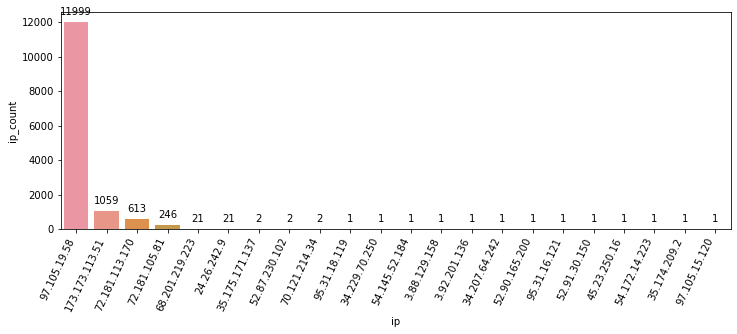

In [7]:
print(len(ip_df))

print(ip_df.tail(10))

#barplot of ip addresses and their counts
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(ha ='right',rotation=65)

In [8]:
#create train from the following dates, with these columns
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','request_path','http_version','status_code','size','user_agent']]

In [9]:
train


,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...
2019-04-17 12:55:12,97.105.19.58,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0
2019-04-17 12:55:12,97.105.19.58,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0
2019-04-17 12:55:13,97.105.19.58,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0


In [10]:
#taking value counts of the ip addresses with these columns, with existing data as our train
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [11]:
#check ip_df
ip_df

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503
5,68.201.219.223,0.001503
6,35.175.171.137,0.000143
7,52.87.230.102,0.000143
8,70.121.214.34,0.000143
9,35.174.209.2,0.000072


In [12]:
df['size_mb_bin']= df['size'].astype(int)

In [13]:
df['status_code']= df.status_code.astype(int)

In [14]:
#assuring all systems a go 
df.dtypes

ip                 object
request_method     object
request_path       object
http_version       object
status_code         int64
size                int64
user_agent         object
size_mb           float64
size_mb_bin         int64
dtype: object

In [15]:
#missing values to 0, merge
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')

In [16]:
#group by ip address, and divide the ip address size by total entries.
ip_probs = train.groupby('ip').size().div(len(df))

#probability of size category given ip address
size_given_ip = pd.DataFrame(train.groupby(['ip', 'size']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_size_category_given_ip'})
                              )

In [17]:
ip_size_count = pd.DataFrame(train.groupby(['ip', 'size'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_size_count'}))


ip_size = size_given_ip.merge(ip_size_count)

In [18]:
df = df.reset_index().merge(ip_size, on=['ip', 'size'], how='left').fillna(value=0).set_index('timestamp')

In [19]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,size_mb_bin,ip_proba,proba_size_category_given_ip,ip_size_count
timestamp,,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,512495,0.858595,0.004419,53.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,3561,0.858595,0.034015,408.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,510103,0.858595,0.004419,53.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377,510003,0.858595,0.004419,53.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246,511963,0.858595,0.008754,105.0


Text(0, 0.5, 'ip_proba')

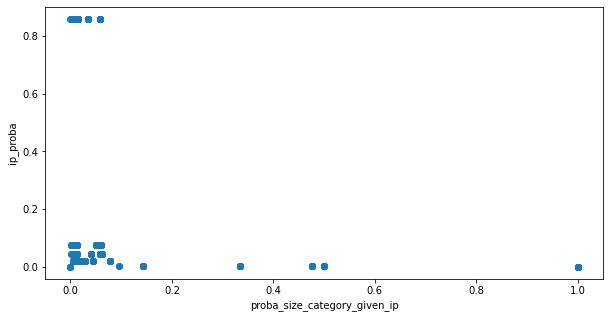

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(df.proba_size_category_given_ip, df.ip_proba)
plt.xlabel('proba_size_category_given_ip')
plt.ylabel('ip_proba')

<BarContainer object of 13978 artists>

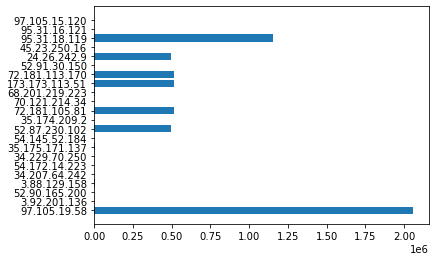

In [21]:
plt.barh(df.ip, df.size_mb_bin)

In [22]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [25]:
# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [26]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [27]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [31]:

#take out quotation marks, and clean up request_method column
for col in ['request_method', 'request_path']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)
df['request_method'] = df['request_method'] + df['request_path'] 

df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET/api/v1/sales?page=81,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET/api/v1/items,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET/api/v1/sales?page=82,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET/api/v1/sales?page=83,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET/api/v1/sales?page=84,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [32]:
#make a df with value counts for ip address
rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_count'})

#make a df with the probability of each ip address
rm_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})

#merge the new dfs
rm_df = rm_df.merge(rm_df2)


# see those where rate < 1% 
rm_df[rm_df.rm_proba < .01]

,request_method,rm_count,rm_proba
6,GET/,107,0.007655
7,GET/documentation,100,0.007154
8,GET/api/v1/sales?page=3,91,0.006510
9,GET/api/v1/items?page=1,88,0.006296
10,GET/api/v1/sales?page=4,83,0.005938
...,...,...,...
215,GET/api/v1/I_DIDNT_DO_IT!!!!,1,0.000072
216,GET/api/v1,1,0.000072
217,GET/api/v1/helloclass!,1,0.000072
218,GET/api/v1/items&page=0,1,0.000072


220
                                 request_method  rm_count  rm_proba
210  GET/api/v1/items?page=99999999999999999998         1  0.000072
211                          GET/api/V1/HiZach!         1  0.000072
212                  GET/api/v1/stores?page=999         1  0.000072
213          GET/api/v1//api/v1/items/next_page         1  0.000072
214                     GET/api/v1/items?page=4         1  0.000072
215                GET/api/v1/I_DIDNT_DO_IT!!!!         1  0.000072
216                                  GET/api/v1         1  0.000072
217                      GET/api/v1/helloclass!         1  0.000072
218                     GET/api/v1/items&page=0         1  0.000072
219                     GET/api/v1/items?page=0         1  0.000072


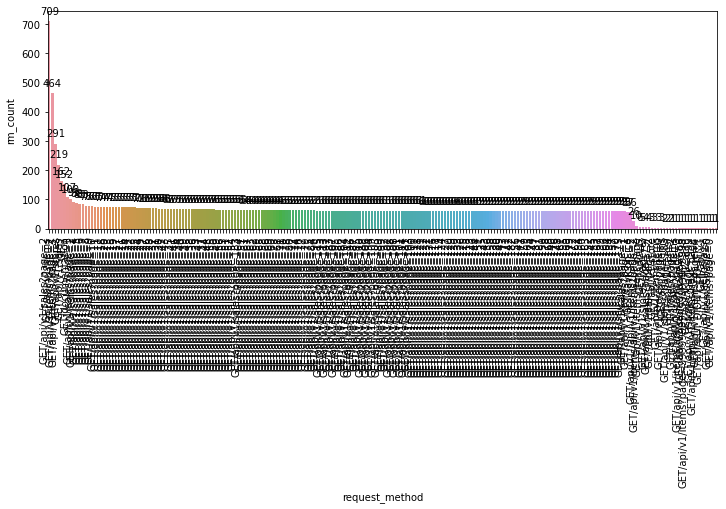

In [34]:
print(len(rm_df))

print(rm_df.tail(10))

#barplot of ip addresses and their counts
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'rm_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(ha ='right',rotation=90)

In [42]:
#create train from the following dates, with these columns
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','size','user_agent','status_code']]

In [43]:
#taking value counts of the ip addresses with these columns, with existing data as our train
rm_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})

In [44]:
#missing values to 0, merge
df = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')

In [46]:
#group by request, and divide the request size by total entries.
rm_probs = train.groupby('request_method').size().div(len(df))

#probability of size category given ip address
rm_given_status = pd.DataFrame(train.groupby(['request_method', 'status_code']).\
                               size().div(len(train)).\
                               div(rm_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_request_method_given_status'}))

In [48]:
rm_status_count = pd.DataFrame(train.groupby(['request_method', 'status_code'])['ip'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'rm_status_count'}))


rm_status = rm_given_status.merge(rm_status_count)

In [51]:
df = df.reset_index().merge(rm_status, on=['request_method', 'status_code'], how='left').fillna(value=0).set_index('timestamp')

In [52]:
df.columns

Index(['ip_x', 'request_method', 'request_path', 'http_version', 'status_code',
       'size', 'user_agent', 'size_mb', 'rm_proba_x', 'rm_proba_y',
       'proba_request_method_given_status', 'rm_status_count', 'ip_y'],
      dtype='object')

In [53]:
plt.scatter(df.proba_request_method_given_status, df.rm_proba)

AttributeError: 'DataFrame' object has no attribute 'rm_proba'